In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ugradiolab.analysis import SpectrumLite

HI_FREQ_HZ = 1420.405751768e6  # HI 21-cm rest frequency

DATA_ROOT = Path('../../data')

long_spectra = sorted(
    [SpectrumLite.load(p) for p in (DATA_ROOT / 'lab_2_1_long_combined_lite').glob('*.npz')],
    key=lambda s: s.center_freq,
)

for s in long_spectra:
    print(f'  LO={s.center_freq/1e6:.0f} MHz   HI offset={(HI_FREQ_HZ - s.center_freq)/1e6:+.3f} MHz')

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  LO=1420 MHz   HI offset=+0.406 MHz
  LO=1421 MHz   HI offset=-0.594 MHz


# Lab 2.1 Analysis — Bandpass Calibration via Spectral Division

## 1 · The signal chain and the FIR bandpass

The RTL-SDR processes the sky signal in two stages before delivering samples:

**Stage 1 — Downconversion.**  
The local oscillator (LO) at frequency $f_c$ mixes the sky down to baseband, so an astronomical signal at absolute frequency $f$ appears at baseband offset $\Delta f = f - f_c$.

**Stage 2 — FIR decimation filter.**  
The RTL chip applies a fixed finite-impulse-response (FIR) filter $h[n]$ in the time domain before passing samples to the host. In the time domain this is a convolution:

$$x_\text{out}[n] = \bigl(x_\text{in} * h\bigr)[n]$$

By the **convolution theorem**, convolution in time is multiplication in frequency:

$$X_\text{out}(\Delta f) = H(\Delta f) \cdot X_\text{in}(\Delta f)$$

where $H(\Delta f) = \mathcal{F}\{h\}$ is the filter's complex frequency response. The observed power spectral density (PSD) is therefore

$$\boxed{P_\text{obs}(\Delta f) = \lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_c + \Delta f)}$$

The characteristic shape seen in every raw spectrum — high at band centre, rolling off toward the edges — is $\lvert H(\Delta f) \rvert^2$, the **power response of the FIR filter**, not a property of the sky. A polynomial or polynomial-fit baseline removal can approximate this shape but cannot recover it exactly.

---

## 2 · Bandpass calibration by spectral division

Because $\lvert H(\Delta f) \rvert^2$ depends only on baseband offset and the hardware configuration (not on $f_c$), it is **identical** for any two observations taken with the same SDR settings. For two observations at LO frequencies $f_{c,1}$ and $f_{c,2}$:

$$P_1(\Delta f) = \lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,1} + \Delta f)$$
$$P_2(\Delta f) = \lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,2} + \Delta f)$$

Dividing bin-by-bin at the **same baseband index**:

$$R(\Delta f) \;\equiv\; \frac{P_1(\Delta f)}{P_2(\Delta f)} \;=\; \frac{\lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,1} + \Delta f)}{\lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,2} + \Delta f)} \;=\; \frac{S_\text{sky}(f_{c,1} + \Delta f)}{S_\text{sky}(f_{c,2} + \Delta f)}$$

**$\lvert H(\Delta f) \rvert^2$ cancels exactly.** $R(\Delta f)$ is a purely astronomical quantity: the ratio of sky brightness temperatures $\lvert f_{c,2} - f_{c,1} \rvert$ apart, sampled at the baseband grid of the first observation. No knowledge of the filter coefficients is required.

---

## 3 · Application to the 1420 / 1421 MHz pair

The HI 21-cm line sits at $f_\text{HI} = 1420.406$ MHz. The two extreme observations give:

| Observation | $f_c$ | HI position $\Delta f = f_\text{HI} - f_c$ |
|:---|:---:|:---:|
| Signal | 1420 MHz | $+0.406$ MHz |
| Reference | 1421 MHz | $-0.594$ MHz |

Computing $R(\Delta f) = P_{1420}(\Delta f)\;/\;P_{1421}(\Delta f)$:

- **At $\Delta f = +0.406$ MHz** — the 1420 MHz capture contains the HI line; the 1421 MHz capture sees only continuum at that offset → $R > 1$, a **peak**.
- **At $\Delta f = -0.594$ MHz** — the 1420 MHz capture sees continuum; the 1421 MHz capture contains the HI line → $R < 1$, a **dip**.
- **Everywhere else** — both captures see spectrally smooth continuum, so $R \approx 1$.

The pair of features (peak and dip separated by $f_{c,2} - f_{c,1} = 1$ MHz) is a direct signature of a narrow spectral line sitting between the two LO settings. The true line profile can be read from either feature alone.

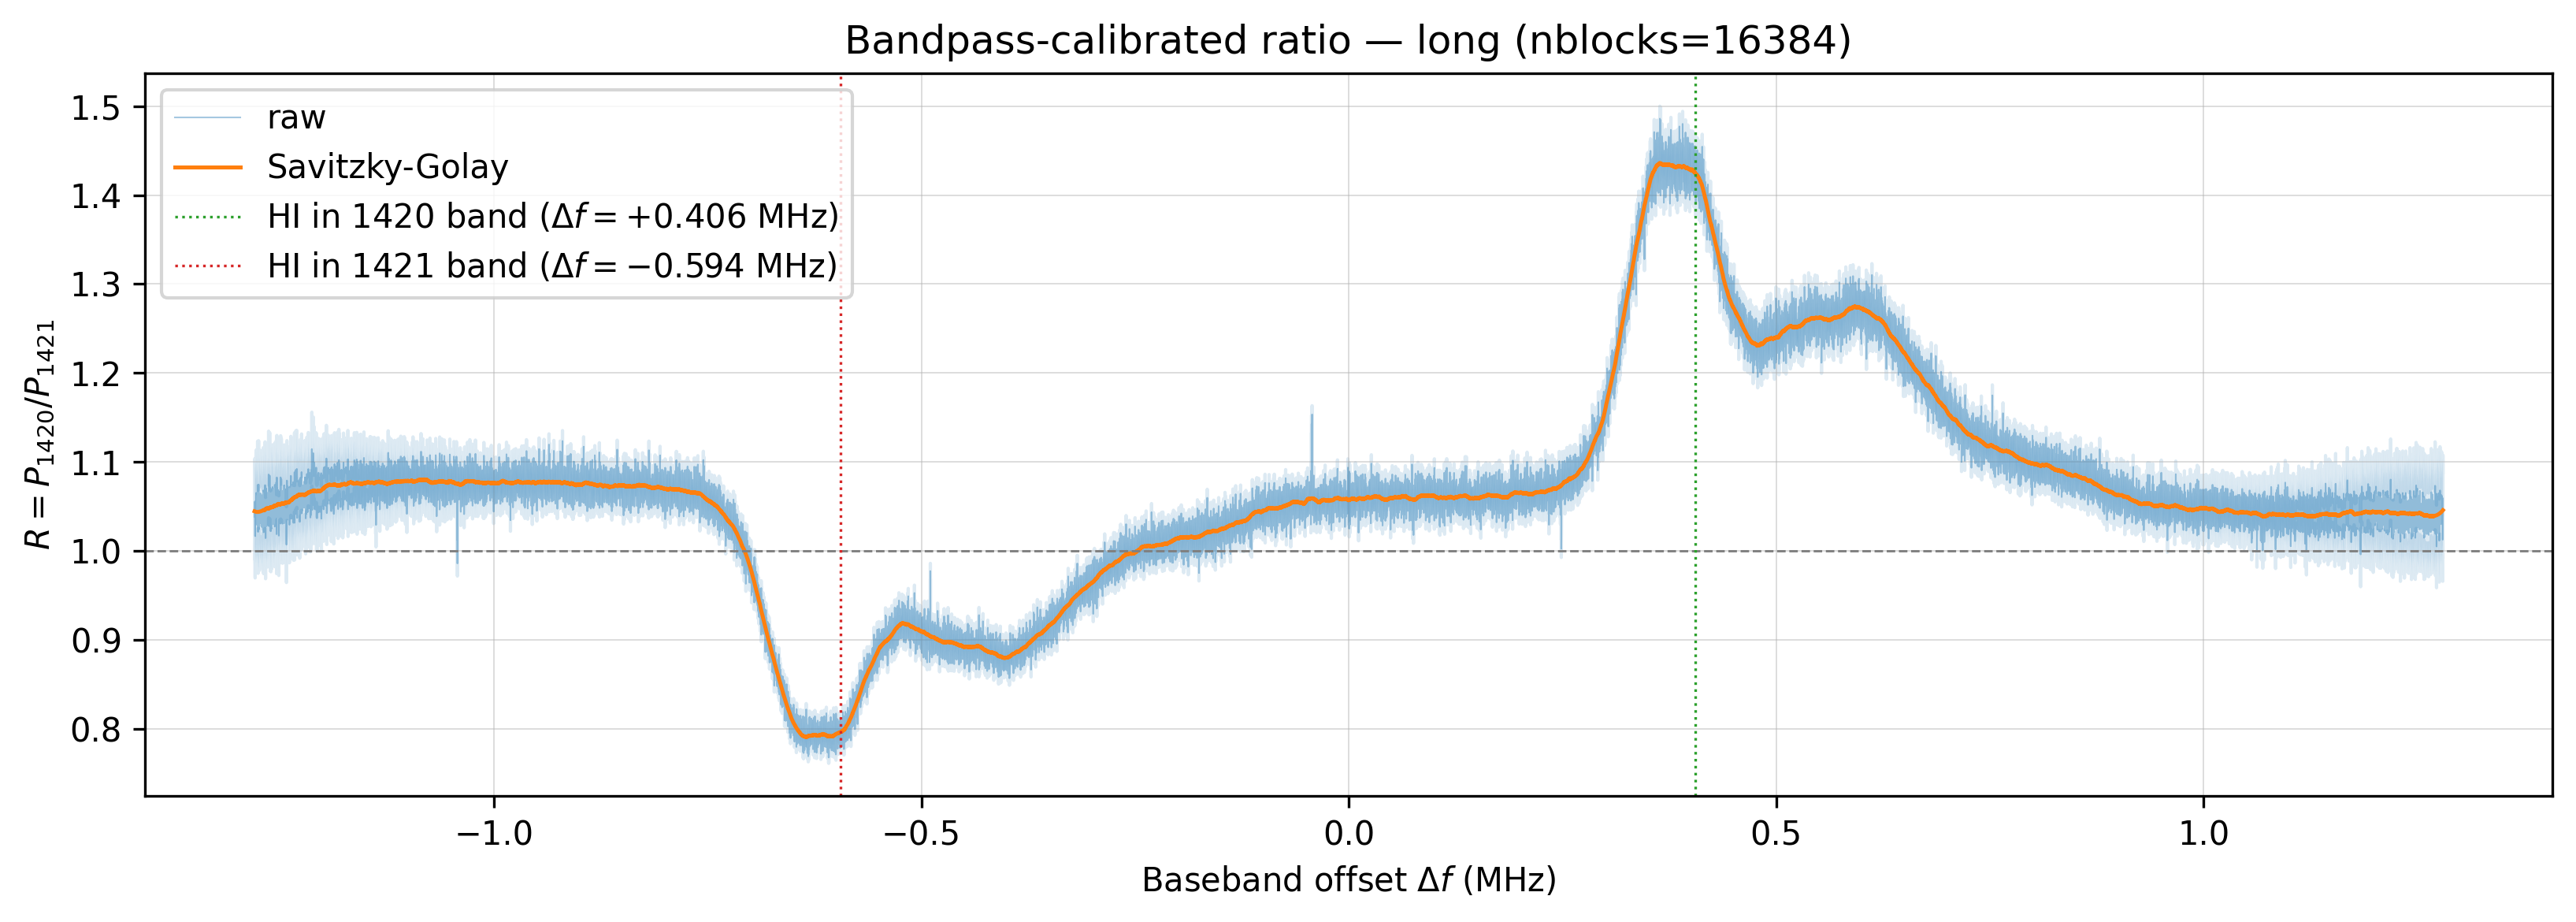

In [2]:
long_1420 = next(s for s in long_spectra if abs(s.center_freq - 1420e6) < 0.5e6)
long_1421 = next(s for s in long_spectra if abs(s.center_freq - 1421e6) < 0.5e6)

baseband_mhz = (long_1420.freqs - long_1420.center_freq) / 1e6

with np.errstate(divide='ignore', invalid='ignore'):
    R = long_1420.psd / long_1421.psd
    sigma_R = R * np.sqrt((long_1420.std / long_1420.psd)**2 + (long_1421.std / long_1421.psd)**2)

psd_1420_smooth = long_1420.smooth(method='savgol', window_length=257, polyorder=3)
psd_1421_smooth = long_1421.smooth(method='savgol', window_length=257, polyorder=3)

with np.errstate(divide='ignore', invalid='ignore'):
    R_smooth = psd_1420_smooth / psd_1421_smooth

fig, ax = plt.subplots(figsize=(11, 4), dpi=300)
ax.fill_between(baseband_mhz, R - sigma_R, R + sigma_R, alpha=0.15, color='C0')
ax.plot(baseband_mhz, R,        lw=0.5, alpha=0.4, color='C0', label='raw')
ax.plot(baseband_mhz, R_smooth, lw=1.2,             color='C1', label='Savitzky-Golay')
ax.axhline(1.0, color='gray', lw=0.7, linestyle='--')
ax.axvline((HI_FREQ_HZ - 1420e6) / 1e6, color='C2', lw=0.8, linestyle=':',
           label=fr'HI in 1420 band ($\Delta f = {(HI_FREQ_HZ - 1420e6)/1e6:+.3f}$ MHz)')
ax.axvline((HI_FREQ_HZ - 1421e6) / 1e6, color='C3',    lw=0.8, linestyle=':',
           label=fr'HI in 1421 band ($\Delta f = {(HI_FREQ_HZ - 1421e6)/1e6:+.3f}$ MHz)')
ax.set_xlabel(r'Baseband offset $\Delta f$ (MHz)')
ax.set_ylabel(r'$R = P_{1420} / P_{1421}$')
ax.set_title(fr'Bandpass-calibrated ratio — long (nblocks={long_1420.nblocks})')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

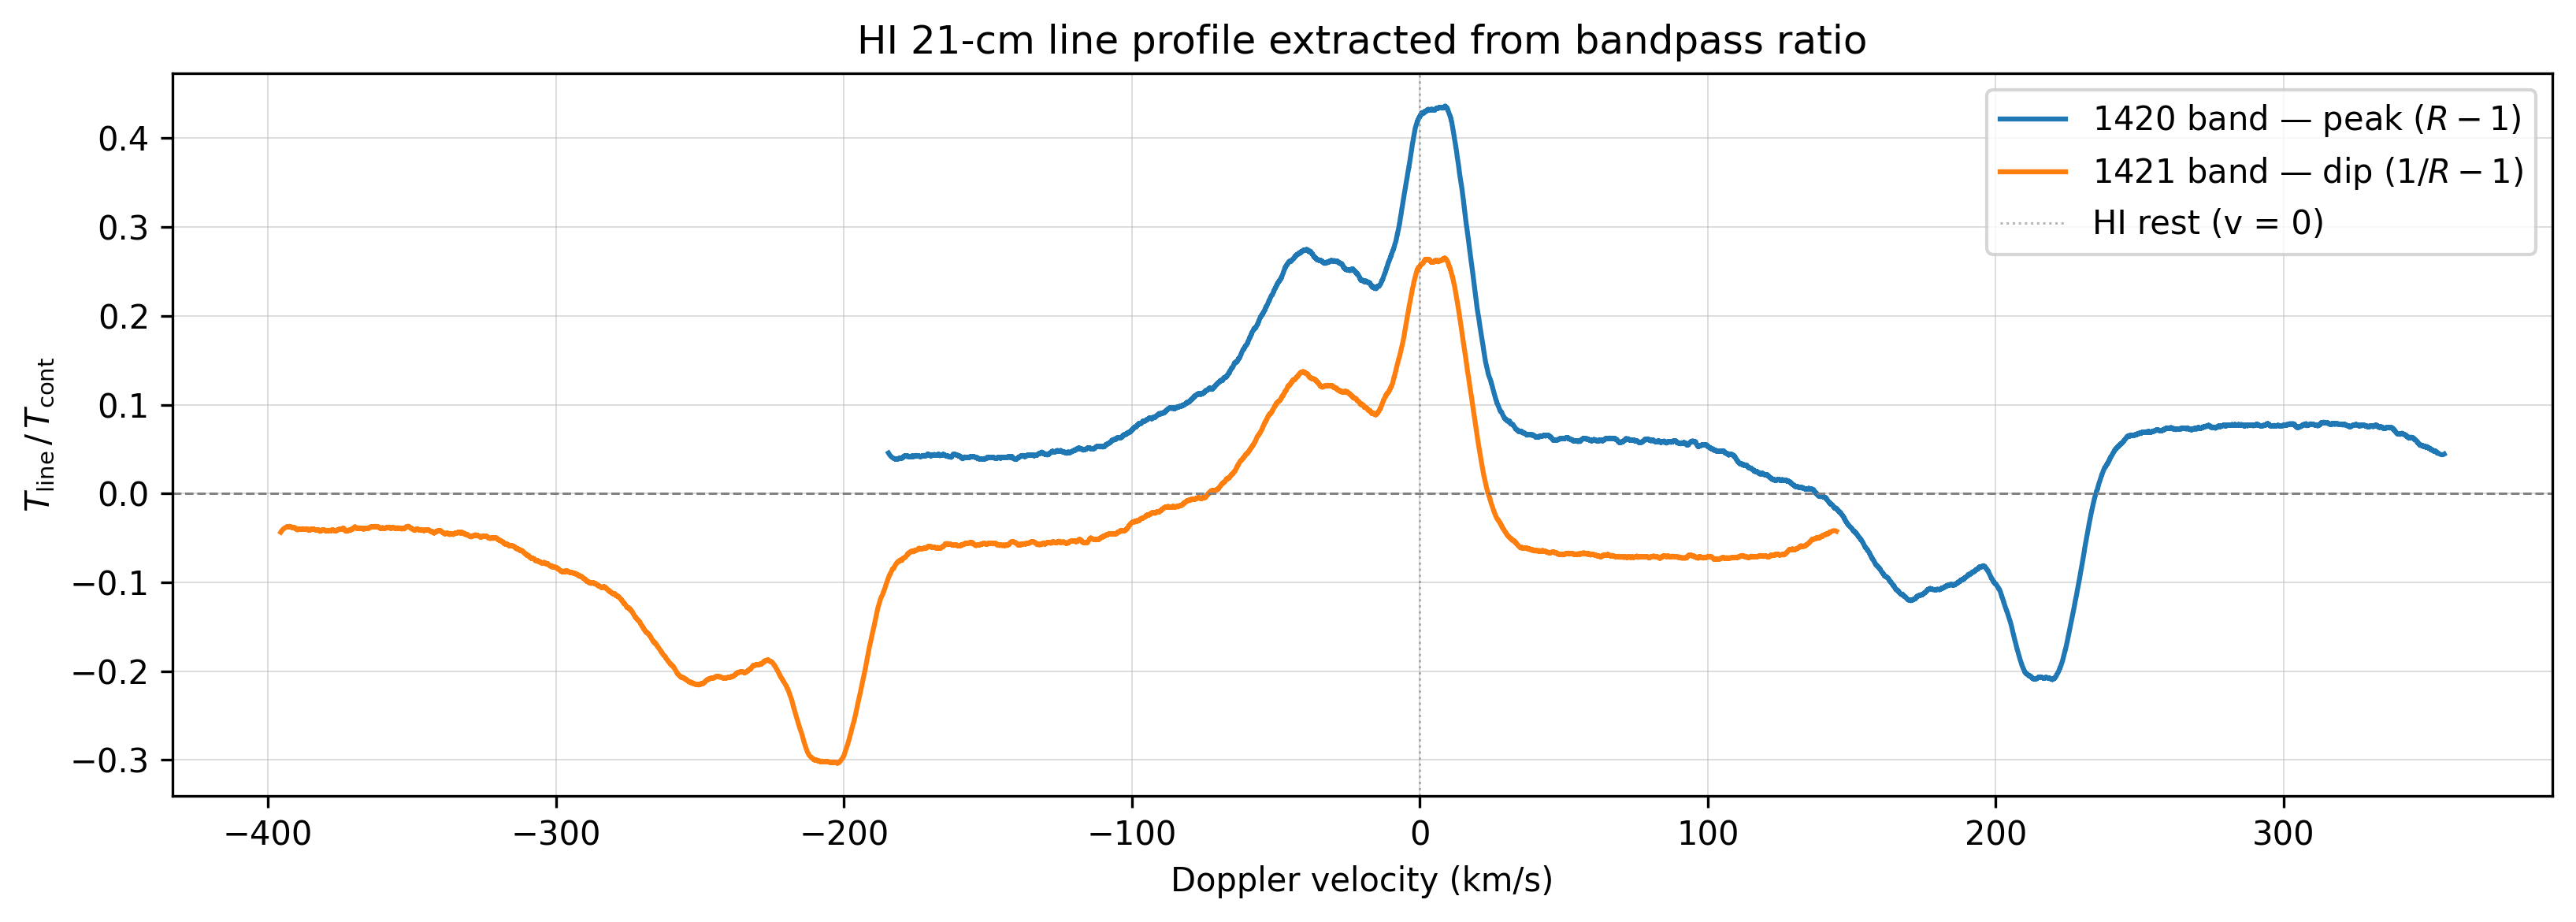

In [3]:
C_LIGHT = 2.998e8  # m/s

# Velocity axis for each band: v = c * (f_HI - f_abs) / f_HI
# long_XXXX.freqs are already absolute frequencies (baseband + LO)
vel_1420 = C_LIGHT * (HI_FREQ_HZ - long_1420.freqs) / HI_FREQ_HZ / 1e3  # km/s
vel_1421 = C_LIGHT * (HI_FREQ_HZ - long_1421.freqs) / HI_FREQ_HZ / 1e3  # km/s

# --- Line profiles: T_line / T_cont ---
# Peak: HI is in the 1420 band; 1421 band is pure continuum at same baseband offset
#   R = (T_cont + T_line) / T_cont  =>  T_line/T_cont = R - 1
profile_peak       = R - 1
sigma_peak         = sigma_R

# Dip: HI is in the 1421 band; 1420 band is pure continuum at same baseband offset
#   R = T_cont / (T_cont + T_line)  =>  T_line/T_cont = 1/R - 1
with np.errstate(divide='ignore', invalid='ignore'):
    profile_dip    = 1.0 / R - 1
    sigma_dip      = sigma_R / R**2   # error propagation through 1/R

profile_peak_smooth = R_smooth - 1
with np.errstate(divide='ignore', invalid='ignore'):
    profile_dip_smooth = 1.0 / R_smooth - 1

# Window: only show ±500 km/s around the HI rest frequency
VEL_WINDOW = 500  # km/s
mask_peak = np.abs(vel_1420) < VEL_WINDOW
mask_dip  = np.abs(vel_1421) < VEL_WINDOW

fig, ax = plt.subplots(figsize=(11, 4), dpi=300)

# 1420 band — peak extraction
# ax.fill_between(vel_1420[mask_peak],
                # (profile_peak - sigma_peak)[mask_peak],
                # (profile_peak + sigma_peak)[mask_peak],
                # alpha=0.15, color='tab:blue')
# ax.plot(vel_1420[mask_peak], profile_peak[mask_peak],
#         lw=0.5, alpha=0.4, color='tab:blue')
ax.plot(vel_1420[mask_peak], profile_peak_smooth[mask_peak],
        lw=1.5, color='tab:blue', label=r'1420 band — peak ($R - 1$)')

# 1421 band — dip extraction
# ax.fill_between(vel_1421[mask_dip],
#                 (profile_dip - sigma_dip)[mask_dip],
#                 (profile_dip + sigma_dip)[mask_dip],
#                 alpha=0.15, color='tab:orange')
# ax.plot(vel_1421[mask_dip], profile_dip[mask_dip],
#         lw=0.5, alpha=0.4, color='tab:orange')
ax.plot(vel_1421[mask_dip], profile_dip_smooth[mask_dip],
        lw=1.5, color='tab:orange', label=r'1421 band — dip ($1/R - 1$)')

ax.axhline(0,  color='gray', lw=0.7, linestyle='--')
ax.axvline(0,  color='gray', lw=0.7, linestyle=':', alpha=0.6, label='HI rest (v = 0)')
ax.set_xlabel('Doppler velocity (km/s)')
ax.set_ylabel(r'$T_\mathrm{line}\,/\,T_\mathrm{cont}$')
ax.set_title('HI 21-cm line profile extracted from bandpass ratio')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()